In [17]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [18]:
def show_img_with_matplotlib(color_img, title, pos):
    """Shows an image using matplotlib capabilities"""

    img_RGB = color_img[:, :, ::-1]

    ax = plt.subplot(1, 1, pos)
    plt.imshow(img_RGB)
    plt.title(title)
    plt.axis('off')


In [27]:
# load the COCO class labels:
class_names = open("coco.names").read().strip().split("\n")

# Load the serialized caffe model from disk:
net = cv2.dnn.readNetFromDarknet("yolov3.cfg", "darknet/yolov3.weights")

# Load input image:
#image = cv2.imread("object_detection_test_image.png")
#image = cv2.imread("cars3.jpg")
(H, W) = image.shape[:2]

H, W

(1600, 1200)

In [28]:
#Get the output layer names:
layer_names = net.getLayerNames()
layer_names = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Create the blob with a size of (416, 416), swap red and blue channels
# and also a scale factor of 1/255 = 0,003921568627451:
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
print(blob.shape)

# Feed the input blob to the network, perform inference and get the output:
net.setInput(blob)
layerOutputs = net.forward(layer_names)

# Get inference time:
t, _ = net.getPerfProfile()
print('Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency()))


(1, 3, 416, 416)
Inference time: 226.91 ms


In [29]:

# Initialization:
boxes = []
confidences = []
class_ids = []

# loop over each of the layer outputs
for output in layerOutputs:
    # loop over each of the detections
    for detection in output:
        # Get class ID and confidence of the current detection:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        # Filter out weak predictions:
        if confidence > 0.25:
            # Scale the bounding box coordinates (center, width, height) using the dimensions of the original image:
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            # Calculate the top-left corner of the bounding box:
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            # Update the information we have for each detection:
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            class_ids.append(class_id)


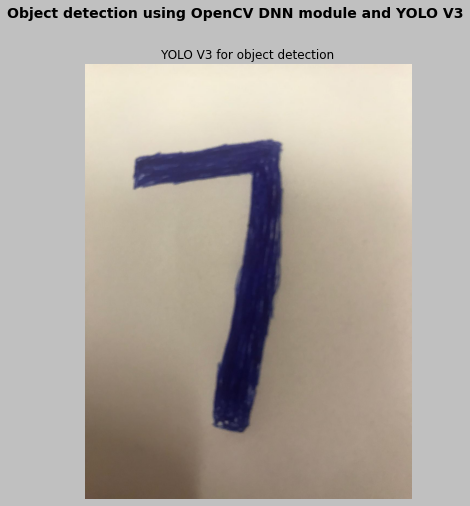

In [30]:
# We can apply non-maxima suppression (eliminate weak and overlapping bounding boxes):
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

# Show the results (if any object is detected after non-maxima suppression):
if len(indices) > 0:
    for i in indices.flatten():
        # Extract the (previously recalculated) bounding box coordinates:
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        # Draw label and confidence:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        label = "{}: {:.4f}".format(class_names[class_ids[i]], confidences[i])
        labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
        y = max(y, labelSize[1])
        cv2.rectangle(image, (x, y - labelSize[1]), (x + labelSize[0], y + 0), (0, 255, 0), cv2.FILLED)
        cv2.putText(image, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

# Create the dimensions of the figure and set title:
fig = plt.figure(figsize=(14, 8))
plt.suptitle("Object detection using OpenCV DNN module and YOLO V3", fontsize=14, fontweight='bold')
fig.patch.set_facecolor('silver')

# Show the output image
show_img_with_matplotlib(image, "YOLO V3 for object detection", 1)

# Show the Figure:
plt.show()
